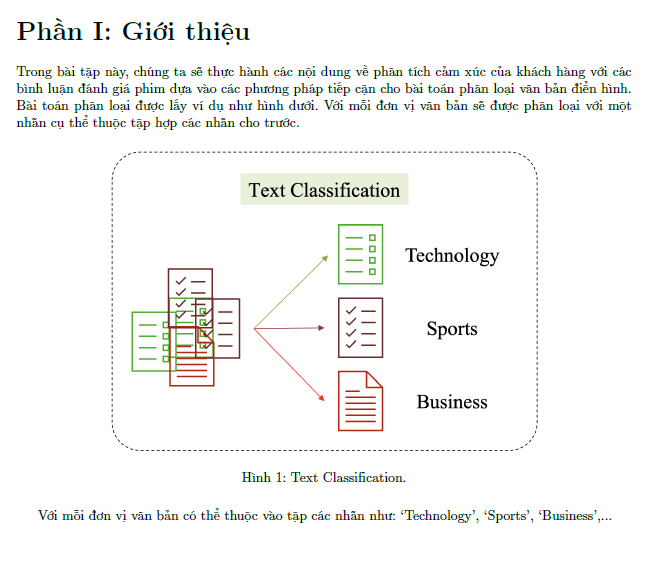
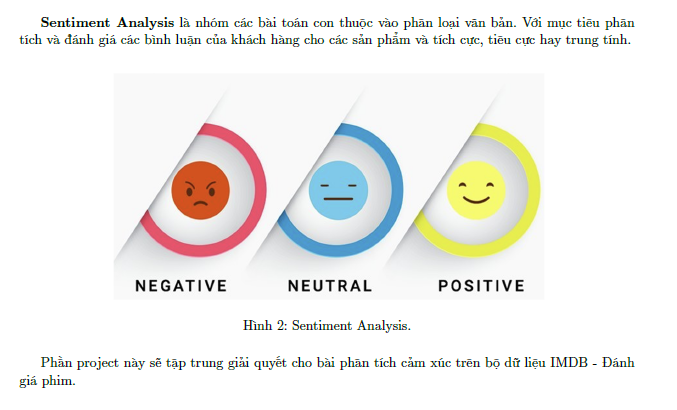
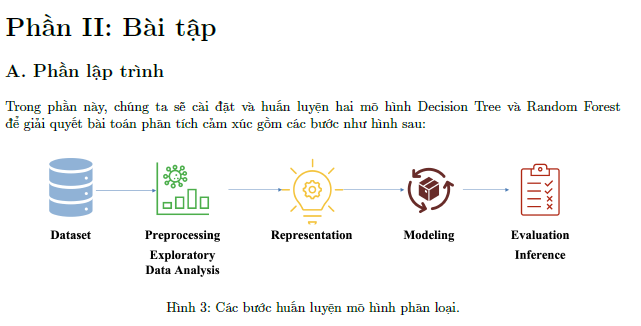

## I. Import necessary libraries

In [1]:
import re
import nltk
import string
import numpy as np
import contractions
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

## II. Implementation

### 1. Import Data

In [2]:
df = pd.read_csv('./Data/IMDB-Dataset.csv')

In [3]:
int(df.duplicated().sum())

418

In [4]:
df = df.drop_duplicates()

### 2. Download necessary NLTK data and set stop words

In [5]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
# Set of English stopwords
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NolanM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\NolanM\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\NolanM\AppData\Roaming\nltk_data...


### 3. Expand Contraction function

In [6]:
def expand_contractions(text):
    return contractions.fix(text)

### 4. Clean and Preprocess text data

In [7]:
def preprocess_text(text):
    wl = WordNetLemmatizer()

    # Removing HTML tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    # Expanding chatwords and contractions
    text = expand_contractions(text)
    # Remove emojis
    emoji_clean = re.compile(
        "["  
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )
    text = emoji_clean.sub(r'', text)
    # Add space after full stop
    text = re.sub(r'\.(?=\S)', '. ', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation and make text lowercase
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    
    # Lemmatize words, remove stopwords, and keep only alphabetic words
    text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()])
    return text

### 5. Apply Preprocessing to a 'review' column in a DataFrame

In [8]:
df['review'] = df['review'].apply(preprocess_text)

C:\Users\NolanM\AppData\Local\Temp\ipykernel_27752\394849280.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [9]:
df['word_count'] = df['review'].apply(lambda x: len(x.split()))
total_word_count = df['word_count'].sum()
print(f"Total word count: {total_word_count}")

Total word count: 5788960


### 6. EDA

#### 6.1 Calculate the frequency of positive and negative sentiments

In [10]:
freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])
# Define Data for the pie chart
data = [freq_pos, freq_neg]
labels = ['positive', 'negative']

#### 6.2 Calculate the number of words in each review

In [11]:
words_len = df['review'].str.split().map(lambda x: len(x))
df_temp = df.copy()
df_temp['words length'] = words_len

#### 6.3 Creating arguments for autopct in pie chart

In [12]:
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

#### 6.4 Visualize (Charts)

##### 6.4.1 Pie Chart

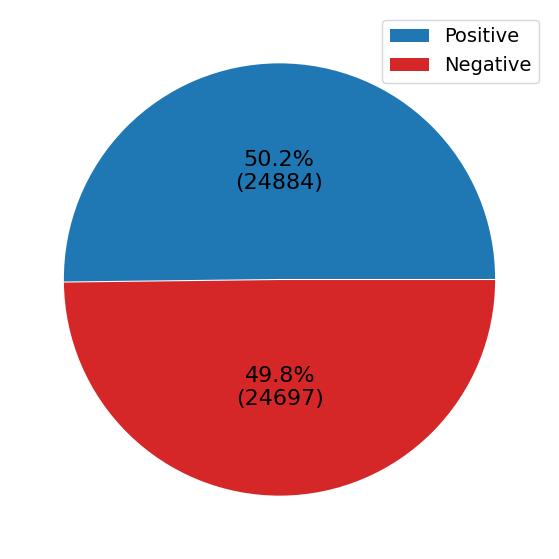

In [13]:
fig, ax = plt.subplots(figsize=[11, 7])
plt.pie(x=data, 
        autopct=lambda pct: func(pct, data), 
        explode=[0.0025] * 2, 
        pctdistance=0.5, 
        colors=[sns.color_palette()[0], 'tab:red'], 
        textprops={'fontsize': 16})
# Add legend
labels = [r'Positive', r'Negative']
plt.legend(labels, loc="best", prop={'size': 14})
fig.savefig("PieChart.png") # Save the pie chart as a PNG image
plt.show()

##### 6.4.2 Histogram Chart

###### 6.4.2.1 Plot for positive reviews

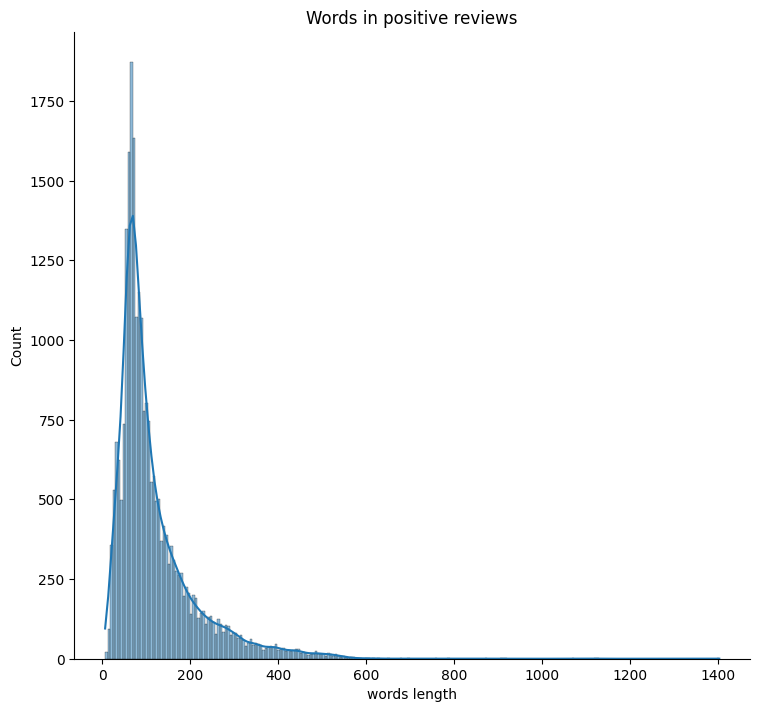

In [14]:
hist_positive = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'positive'],
    x="words length", hue="sentiment", kde=True, height=7, aspect=1.1, legend=False
).set(title='Words in positive reviews')
plt.show(hist_positive)

###### 6.4.2.2 Plot for negative reviews

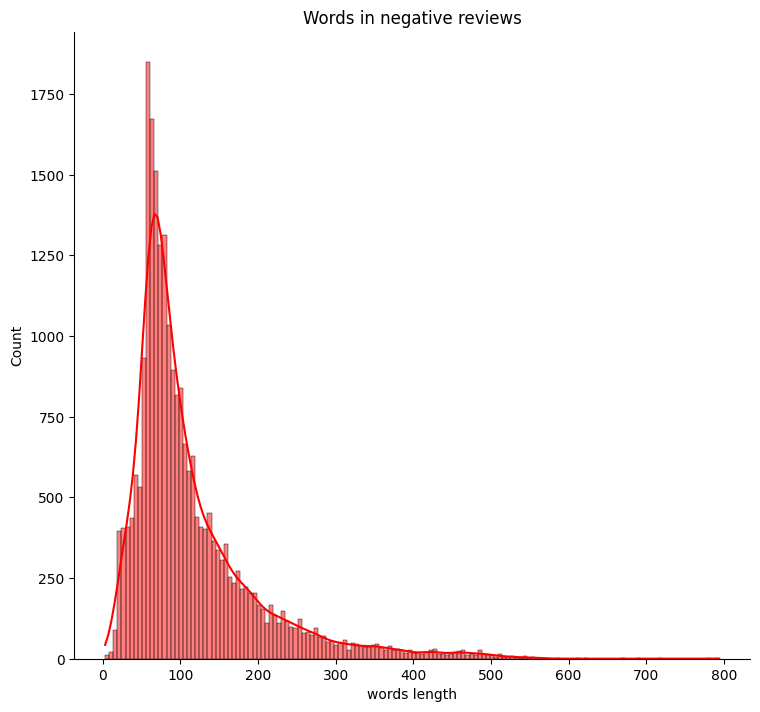

In [15]:
hist_negative = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'negative'],
    x="words length", hue="sentiment", kde=True, height=7, aspect=1.1, legend=False, palette=['red']
).set(title='Words in negative reviews')
plt.show(hist_negative)

##### 6.4.3 KDE Plot for distribution of words length in reviews

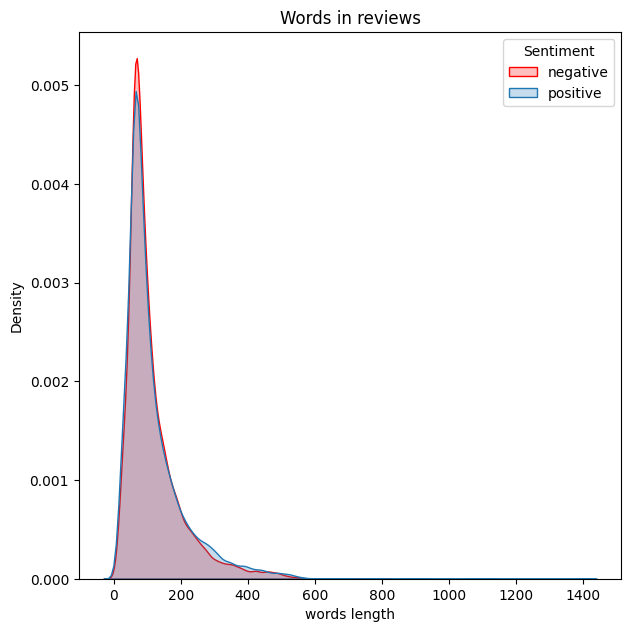

In [16]:
plt.figure(figsize=(7, 7.1))
kernel_distribution_number_words_plot = sns.kdeplot(
    data=df_temp, x="words length", hue="sentiment", fill=True, palette=[sns.color_palette()[0], 'red']
).set(title='Words in reviews')
plt.legend(title='Sentiment', labels=['negative', 'positive'])
plt.show(kernel_distribution_number_words_plot)

### 7. Split train and test data

In [17]:
# Encode sentiment labels
label_encode = LabelEncoder()
x_data = df['review']
y_data = label_encode.fit_transform(df['sentiment'])
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)

### 8. Transform text to vectors using TF-IDF

In [18]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(x_train, y_train)
# Transform train and test data
x_train_encoded = tfidf_vectorizer.transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)

### 9. Train and evaluate the model

#### 9.1. Train a Decision Tree Classifier

In [19]:
dt_classifier = DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)
dt_classifier.fit(x_train_encoded, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

##### Make predictions on the test data

In [20]:
y_pred = dt_classifier.predict(x_test_encoded)

##### Evaluate accuracy

In [21]:
accuracy = accuracy_score(y_pred, y_test)
print(f"Decision Tree Accuracy: {accuracy:.2f}")

Decision Tree Accuracy: 0.72


#### 9.2. Train a Random Forest Classifier

In [22]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(x_train_encoded, y_train)

RandomForestClassifier(random_state=42)

##### Make predictions on the test data

In [23]:
y_pred = rf_classifier.predict(x_test_encoded)

##### Evaluate accuracy

In [24]:
accuracy_score(y_pred, y_test)

0.8412826459614803

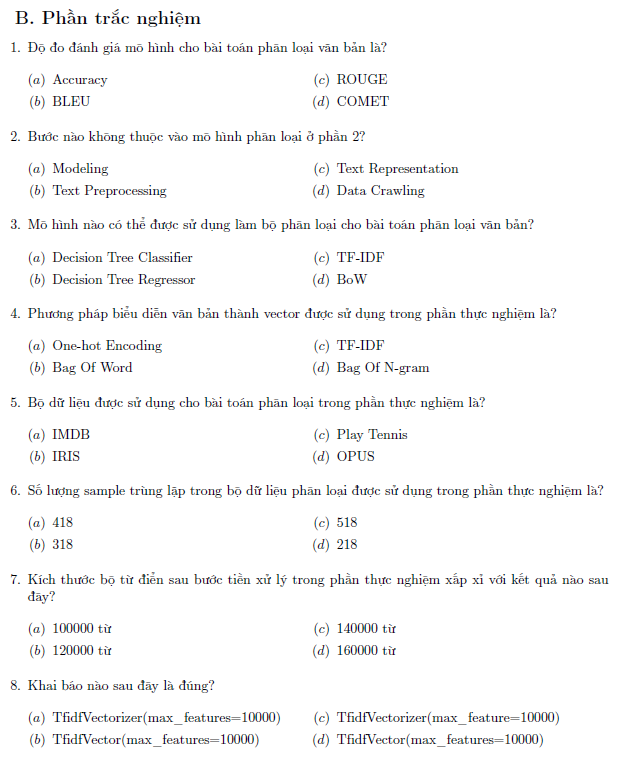
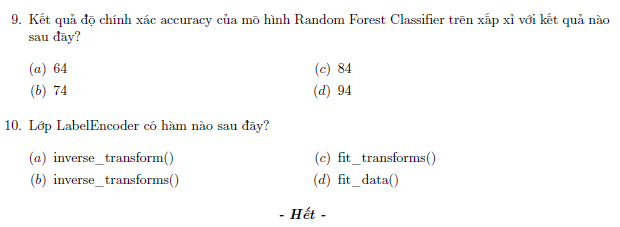

1. A, 2. C, 3. A, 4. C, 5. A, 6. A, 7. B, 8. A, 9. C, 10. C